In [1]:
import fb
import requests

# generate a token: https://developers.facebook.com/tools/explorer/

# this one is mine and no longer valid by the time you run this, of course ;)
access_token='CAACEdEose0cBAKl4sr5nhRi46T8s10gllsFE0rFa9pNkSF9fZCqBKN8dEUwV7taVipFTGJpmFQLPZAXZA7eBZApQoenCeJNUh0aJosk0J17tJ0DQoBMkLmQjeNbtC95wB56kyYbtLfC9NfZCfL0hsUDItWNuFveZBZAdAxtZAHozJuJ52kZAgaKqhbMge0wWoaG6P2yqcCrPQFotWc8W8a5Rz'

# find your user id here, based on your username: http://findmyfbid.com/
user_id='513144150'

In [5]:
face=fb.graph.api(access_token)

In [3]:
## May take a while depending on how many posts there are until (including) 2010.
all_posts = []
posts = face.get_object(cat='single', id='me', fields=['posts'], limit=100)

posts = posts['posts']
datum = posts['data'][0]['created_time']
while datum.startswith('201'):
    for idx, posts_data in enumerate(posts['data']):
        datum = posts_data['created_time']
        if 'message' in posts_data and datum.startswith('201') :
            all_posts.append(posts_data['message'])
            # print "created... %s " % posts_data['created_time']
    posts = requests.get(posts['paging']['next']).json()

In [7]:
all_photos = []
photos = face.get_object(cat='single', id='me', fields=['photos'], limit=100)

photos = photos['photos']
datum = photos['data'][0]['created_time']
while datum.startswith('201'):
    for idx, photos_data in enumerate(photos['data']):
        datum = photos_data['created_time']
        if 'name' in photos_data and datum.startswith('201') :
            all_photos.append(photos_data['name'])
            # print "created... %s " % posts_data['created_time']
    photos = requests.get(photos['paging']['next']).json()
    

In [8]:
len(all_photos) # strange, doesn't pick all my photos, ignore for now. #TODO check FB API

11

In [9]:
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords

In [10]:
def review_to_words(raw_review):
    # Remove non-letters       
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    # convert to lower case, split into words
    words = letters_only.lower().split()
    # searching a set is much faster than searching a list, so convert to set first
    stops_english = set(stopwords.words("english"))
    stops_dutch = set(stopwords.words("dutch"))
    # remove stopwords
    meaningful_words = [w.lower() for w in words if not w in stops_english and not w in stops_dutch]
    # 6. join the words into one string separated by space
    return(" ".join(meaningful_words))

In [11]:
clean_posts = []

for post in all_posts:
    clean_posts.append(review_to_words(post))

In [12]:
import gensim
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [13]:
def docList(docs):
    for doc in docs:
        tokens = tokenizer.tokenize(doc)
        tokens = [ t for t in tokens ]
        yield tokens

In [14]:
dic = gensim.corpora.Dictionary.from_documents(docList(clean_posts))

In [15]:
# dic.items()
dic.save('facebook_posts_vocab.gensim.dic')

In [16]:
corpus = [dic.doc2bow(post) for post in docList(clean_posts)]

In [17]:
from scipy.sparse import csr_matrix
data = []
row  = []
col  = []
for n,doc in enumerate(corpus):
    for w,c in doc:
        col.append(n)
        row.append(w)
        data.append(c)

nSamples = len(corpus)
nFeatures = len(dic)
mm = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))

In [18]:
print "nSamples (posts) : ",nSamples
print "nFeatures(words): ",nFeatures
len(corpus),len(dic)

nSamples (posts) :  1795
nFeatures(words):  3222


(1795, 3222)

In [19]:
nTopics = 10
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=nTopics, max_iter=10,
                                learning_method='online', learning_offset=50.
                                #,random_state=0
                               )
lda.fit(mm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [20]:
def getDocumentTopics(docTokens, lda):
    wcTuples = dic.doc2bow(docTokens)
    data = []
    row  = []
    col  = []

    for w,c in wcTuples:
        col.append(0)
        row.append(w)
        data.append(c)

    nSamples = 1
    nFeatures = len(dic)
    oneDoc = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))
    docWeights = lda.transform(oneDoc)[0]
    docWeights /= docWeights.sum()
    return docWeights

topicWords = []
topicWeightedWords = []

for topic_idx, topic in enumerate(lda.components_):
    weightedWordIdx = topic.argsort()[::-1]
    wordsInTopic = [dic[i] for i in weightedWordIdx[:10]]

    weights = topic / topic.sum()
    topicWeights = [ (weights[i],dic[i]) for i in weightedWordIdx[:10]]
    
    print "Topic #%d:" % topic_idx
    print " ".join(wordsInTopic)
    topicWords.append(wordsInTopic)
    topicWeightedWords.append(topicWeights)

Topic #0:
amsterdam night true cern science m re day summer going
Topic #1:
se vo najdobro godina novata da live christmas ne od
Topic #2:
tropez st day like thanks got feel ago big damn
Topic #3:
new skopje see york beach called world oldtimers brain nice
Topic #4:
time best something art word lazagna birthday architecture zen party
Topic #5:
google love oh well http com www know thank things
Topic #6:
real right x back life hell sweden via et win
Topic #7:
e must progress say away photo run words courtesy festival
Topic #8:
m good take p first getting would morning talk finally
Topic #9:
song beautiful sad d one need dutch people making paprika


In [22]:
# nTopics = 10
%pylab inline
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

img = []
for idx,topic in enumerate(topicWeightedWords):
    wc = WordCloud(background_color="white")
    img.append(wc.generate_from_frequencies([ (word, weight) for weight,word in topic ]))
#     subplot(nTopics,2,2*idx+1)
#     imshow(img)
#     axis('off')
#     imshow(img)

Populating the interactive namespace from numpy and matplotlib


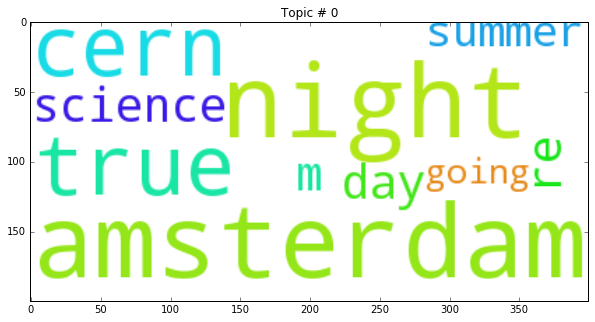

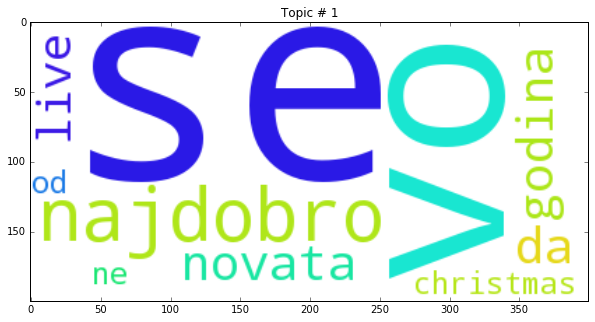

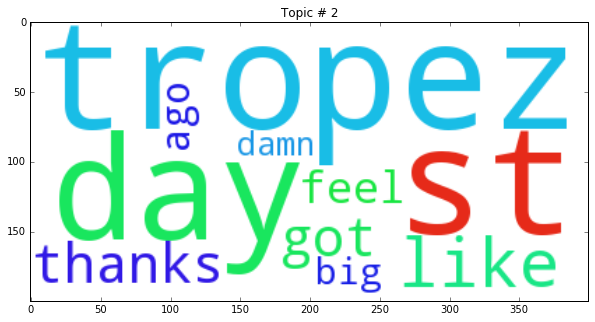

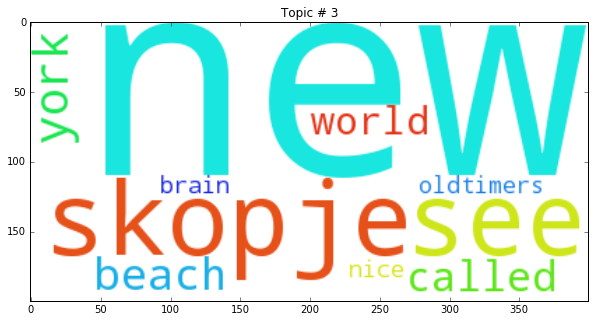

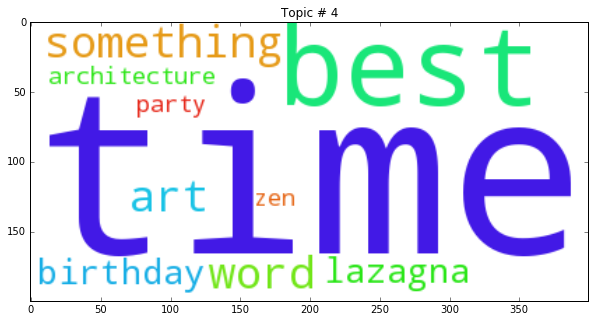

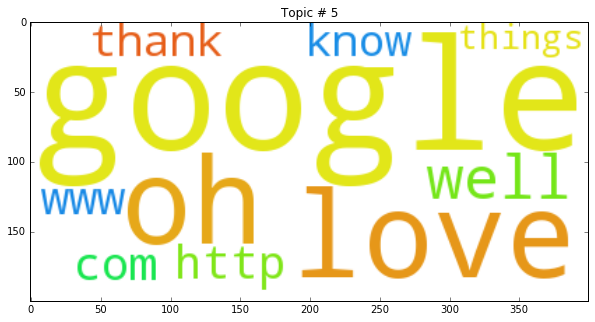

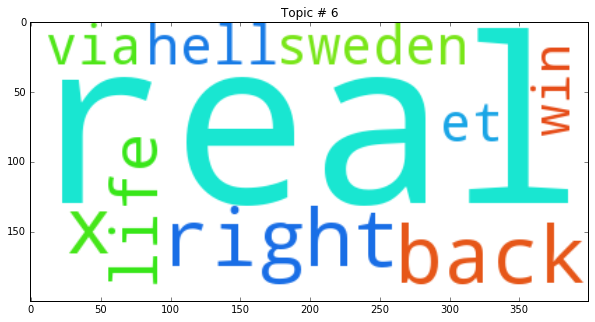

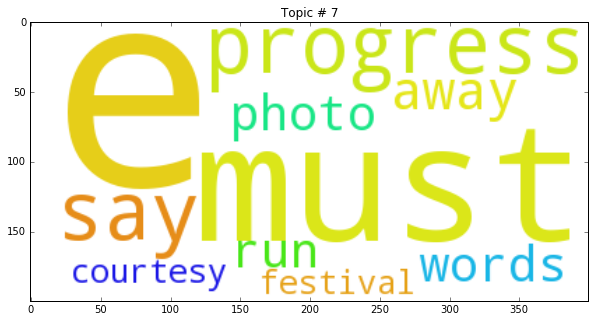

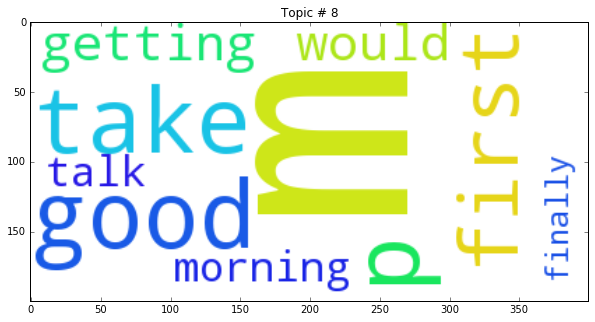

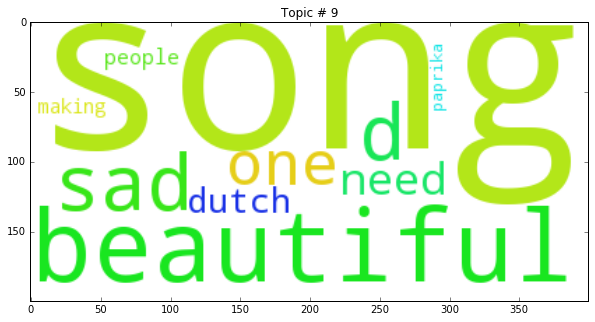

In [23]:
for idx, im in enumerate(img):
    figure(figsize=(10,5))
    title('Topic #%2d'%(idx))
    imshow(im)